In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("../incl/")


In [11]:
%matplotlib notebook


import os
from natsort import realsorted


def get_scans(path):

    filenames = []
    # r=root, d=directories, f = filenames
    for r, d, f in os.walk(path):
        for file in f:
            if 'rdim_' in file:
                filenames.append(os.path.join(r, file))

    filenames = realsorted(filenames)

    # ##print filenames
#     for f in filenames:
#         print(f)
    # nYdata = len(filenames)
    # print(nYdata)

    scans = [] # that data goes into this list
    for fn in filenames:
      scans.append(np.loadtxt(fn)) #load linescan an append to the list of linescans - each linescan is matrix

    scans = np.asarray(scans) #create numpy ndarray from list -- contains all the data -- format [number of files, sweep steps, data column]
#     print (scans.shape)

    scans = np.reshape(scans,(36,36,6))
#     print(scans.shape)

    return scans



In [17]:
path = '/home/agluedge/Preprints/ELPH/data/run14_ELM_optimization_SEED_102/data/'

scans = get_scans(path)

std_scores = scans[:,:,0] + scans[:,:,1]
max_scores = scans[:,:,2] + scans[:,:,3]

In [24]:
seeds = [101,102]

scores_list = []
for s in seeds:
    path = '/home/agluedge/Preprints/ELPH/data/run14_ELM_optimization_SEED_' + str(s) + '/data/'
    
    scans = get_scans(path)

    std_scores = scans[:,:,0] + scans[:,:,1]
    max_scores = scans[:,:,2] + scans[:,:,3]
    
    scores_list.append(std_scores)


scores_list = np.asarray(scores_list)
    
std_scores = np.mean(scores_list, axis=0)

In [18]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=False):
        """
        Map value to the interval [0, 1]. The clip argument is unused.
        """
        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)  # sets self.vmin, self.vmax if None

        if not self.vmin <= self.vcenter <= self.vmax:
            raise ValueError("vmin, vcenter, vmax must increase monotonically")
        result = np.ma.masked_array(
            np.interp(result, [self.vmin, self.vcenter, self.vmax],
                      [0, 0.5, 1.]), mask=np.ma.getmask(result))
        if is_scalar:
            result = np.atleast_1d(result)[0]
        return result


<IPython.core.display.Javascript object>


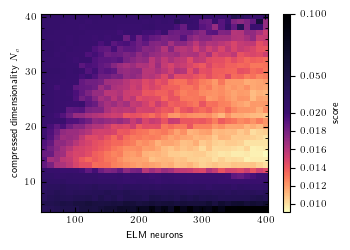

In [26]:

scores = std_scores


VMAX = 0.1

###########
###########

ny,nx = scores.shape

xmin = 50
xmax = 400

ymin = 5
ymax = 40


dx = (xmax-xmin)/(nx-1)/2
dy = (ymax-ymin)/(ny-1)/2

extent = [xmin-dx,xmax+dx,ymin-dy,ymax+dy]


scores = np.ma.masked_greater(scores, VMAX*2)


xlim_min = xmin - dx
xlim_max = xmax + dx

ylim_min = ymin - dy
ylim_max = ymax + dy



####################################################
####################################################
####################################################

from matplotlib import rc
rc('text', usetex=True)

from matplotlib import gridspec
import matplotlib.ticker as ticker
from matplotlib import colors

fs = 7
fig = plt.figure(figsize=(3.5,2.5))
plt.rcParams.update({'font.size': fs})
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1,0.03], height_ratios=[1])



####################################################
####################################################
####################################################


vmin = scores.min()
vcenter = 0.02 # scores.min()*2
vmax = 0.1 #scores.max()


# norm = colors.LogNorm(vmax=VMAX)
# norm = MidpointNormalize(vmin=vmin, vcenter=vcenter, vmax=vmax)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)


colors_lower = plt.cm.magma_r(np.linspace(0, 0.8, 256))
colors_upper = plt.cm.magma_r(np.linspace(0.8, 1, 256))
all_colors = np.vstack((colors_lower, colors_upper))
error_cmap = colors.LinearSegmentedColormap.from_list(
    'error_cmap', all_colors)



####################################################


ax00 = plt.subplot(gs[0,0])

# im = plt.imshow(scores, origin='lower', interpolation='none', aspect='auto', vmax=VMAX, extent=extent, cmap='magma_r')

im = plt.imshow(scores, origin='lower', interpolation='none', aspect='auto', norm=norm, extent=extent, cmap=error_cmap)


# plt.colorbar()

    
plt.xlabel(r'ELM neurons')
plt.ylabel(r'compressed dimensionality $N_c$')

plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)


ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(20))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(2))
# ax00.yaxis.set_major_formatter(ticker.NullFormatter())
# ax00.yaxis.set_minor_formatter(ticker.NullFormatter())


# plt.text(0.03, 0.97,r'(a)', color='k', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)



axCB = plt.subplot(gs[0,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"score")

axCB.yaxis.set_major_locator(ticker.FixedLocator([0.01,0.012,0.014,0.016,0.018,0.02,0.05,0.1]))

####################################################
####################################################
####################################################

plt.tight_layout()

# plt.subplots_adjust(left=0.11, bottom=0.09, right=0.84, top=0.97, wspace=0.05, hspace=0.3)

plt.savefig('/home/agluedge/Preprints/ELPH/figs/ELM_opt.pdf', dpi=600)
plt.show()